<a href="https://colab.research.google.com/github/ajaym416/GAN/blob/main/variational_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# import tensorflow as tf
# tf.compat.v1.enable_eager_execution()

In [3]:
##utils-> callbacks
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

#### CALLBACKS
class CustomCallback(Callback):
    
    def __init__(self, run_folder, print_every_n_batches, initial_epoch, vae):
        self.epoch = initial_epoch
        self.run_folder = run_folder
        self.print_every_n_batches = print_every_n_batches
        self.vae = vae

    def on_train_batch_end(self, batch, logs={}):  
        if batch % self.print_every_n_batches == 0:
            z_new = np.random.normal(size = (1,self.vae.z_dim))
            reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

            filepath = os.path.join(self.run_folder, 'images', 'img_' + str(self.epoch).zfill(3) + '_' + str(batch) + '.jpg')
            if len(reconst.shape) == 2:
                plt.imsave(filepath, reconst, cmap='gray_r')
            else:
                plt.imsave(filepath, reconst)

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch += 1



def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        
        return new_lr

    return LearningRateScheduler(schedule)



In [4]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

import tensorflow as tf


import numpy as np
import json
import os
import pickle

class Sampling(Layer):
    def call(self, inputs):
        mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon


class VAEModel(Model):
    def __init__(self, encoder, decoder, r_loss_factor, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.r_loss_factor = r_loss_factor
        self.built = True

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.square(data - reconstruction), axis = [1,2,3]
            )
            reconstruction_loss *= self.r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis = 1)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)





class VariationalAutoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , r_loss_factor
        , use_batch_norm = False
        , use_dropout= False
        ):

        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.r_loss_factor = r_loss_factor

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):
        
        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        self.z = Sampling(name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, [self.mu, self.log_var, self.z], name = 'encoder')
        
        

        ### THE DECODER

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

            

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output, name = 'decoder')

        ### THE FULL VAE

        self.model = VAEModel(self.encoder, self.decoder, self.r_loss_factor)



    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer)


    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
        
        # checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        # checkpoint_filepath=os.path.join(run_folder, "weights/weights.h5")
        # checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )



    def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1, ):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        # checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
        # checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:02d}.h5")
        # checkpoint_filepath=os.path.join(run_folder, "weights/weights.h5")
        # checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
        checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint2, custom_callback, lr_sched]

        self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))


        self.model.fit(
            data_flow
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
            , steps_per_epoch=steps_per_epoch 
            )




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)



In [5]:
#@title Loaders.py

import pickle
import os

from tensorflow.keras.datasets import mnist, cifar100,cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array

import pandas as pd
from PIL import Image
import numpy as np
from os import walk, getcwd
import h5py

import imageio
from glob import glob

from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

import pdb


class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size 
                , class_mode='other'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size 
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow




class DataLoader():
    def __init__(self, dataset_name, img_res=(256, 256)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./data/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                img = np.array(Image.fromarray(img).resize(self.img_res))

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                img = np.array(Image.fromarray(img).resize(self.img_res))
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./data/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./data/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                img_A = np.array(Image.fromarray(img_A).resize(self.img_res))
                img_B = np.array(Image.fromarray(img_B).resize(self.img_res))

                if not is_testing and np.random.random() > 0.5:
                    img_A = np.fliplr(img_A)
                    img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def load_img(self, path):
        img = self.imread(path)
        img = np.array(Image.fromarray(img).resize(self.img_res))
        img = img/127.5 - 1.
        return img[np.newaxis, :, :, :]

    def imread(self, path):
        return imageio.imread(path, pilmode='RGB').astype(np.uint8)




def load_model(model_class, folder):
    
    with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
        params = pickle.load(f)

    model = model_class(*params)

    model.load_weights(os.path.join(folder, 'weights/weights.h5'))

    return model


def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = x_test.astype('float32') / 255.
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)

def load_mnist_gan():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = (x_train.astype('float32') - 127.5) / 127.5
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = (x_test.astype('float32') - 127.5) / 127.5
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)



def load_fashion_mnist(input_rows, input_cols, path='./data/fashion/fashion-mnist_train.csv'):
    #read the csv data
    df = pd.read_csv(path)
    #extract the image pixels
    X_train = df.drop(columns = ['label'])
    X_train = X_train.values
    X_train = (X_train.astype('float32') - 127.5) / 127.5
    X_train = X_train.reshape(X_train.shape[0], input_rows, input_cols, 1)
    #extract the labels
    y_train = df['label'].values
    
    return X_train, y_train

def load_safari(folder):

    mypath = os.path.join("./data", folder)
    txt_name_list = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        for f in filenames:
            if f != '.DS_Store':
                txt_name_list.append(f)
                break

    slice_train = int(80000/len(txt_name_list))  ###Setting value to be 80000 for the final dataset
    i = 0
    seed = np.random.randint(1, 10e6)

    for txt_name in txt_name_list:
        txt_path = os.path.join(mypath,txt_name)
        x = np.load(txt_path)
        x = (x.astype('float32') - 127.5) / 127.5
        # x = x.astype('float32') / 255.0
        
        x = x.reshape(x.shape[0], 28, 28, 1)
        
        y = [i] * len(x)  
        np.random.seed(seed)
        np.random.shuffle(x)
        np.random.seed(seed)
        np.random.shuffle(y)
        x = x[:slice_train]
        y = y[:slice_train]
        if i != 0: 
            xtotal = np.concatenate((x,xtotal), axis=0)
            ytotal = np.concatenate((y,ytotal), axis=0)
        else:
            xtotal = x
            ytotal = y
        i += 1
        
    return xtotal, ytotal



def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)


def load_celeb(data_name, image_size, batch_size):
    data_folder = os.path.join("./data", data_name)

    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x_train = data_gen.flow_from_directory(data_folder
                                            , target_size = (image_size,image_size)
                                            , batch_size = batch_size
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                                )

    return x_train


def load_music(data_name, filename, n_bars, n_steps_per_bar):
    file = os.path.join("./data", data_name, filename)

    with np.load(file, encoding='bytes', allow_pickle = True) as f:
        data = f['train']

    data_ints = []

    for x in data:
        counter = 0
        cont = True
        while cont:
            if not np.any(np.isnan(x[counter:(counter+4)])):
                cont = False
            else:
                counter += 4

        if n_bars * n_steps_per_bar < x.shape[0]:
            data_ints.append(x[counter:(counter + (n_bars * n_steps_per_bar)),:])


    data_ints = np.array(data_ints)

    n_songs = data_ints.shape[0]
    n_tracks = data_ints.shape[2]

    data_ints = data_ints.reshape([n_songs, n_bars, n_steps_per_bar, n_tracks])

    max_note = 83

    where_are_NaNs = np.isnan(data_ints)
    data_ints[where_are_NaNs] = max_note + 1
    max_note = max_note + 1

    data_ints = data_ints.astype(int)

    num_classes = max_note + 1

    
    data_binary = np.eye(num_classes)[data_ints]
    data_binary[data_binary==0] = -1
    data_binary = np.delete(data_binary, max_note,-1)

    data_binary = data_binary.transpose([0,1,2, 4,3])
    
    

    

    return data_binary, data_ints, data


def preprocess_image(data_name, file, img_nrows, img_ncols):

    image_path = os.path.join('./data', data_name, file)

    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [6]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

os.makedirs(RUN_FOLDER,exist_ok = True)
os.makedirs(os.path.join(RUN_FOLDER, 'viz'),exist_ok = True)
os.makedirs(os.path.join(RUN_FOLDER, 'images'),exist_ok = True)
os.makedirs(os.path.join(RUN_FOLDER, 'weights'),exist_ok = True)
mode =  'build' #'load' #

In [7]:
(x_train, y_train), (x_test, y_test) = load_mnist()


11501568/11490434 [==============================] - 0s 0us/step


In [8]:

vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
    , r_loss_factor = 1000
)
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE)
if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
vae.encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 28, 28, 32)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 14, 14, 64)   18496       ['leaky_re_lu[0][0]']            
                                                                                            

In [10]:
vae.decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 decoder_conv_t_1 (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                   

In [11]:
BATCH_SIZE = 32
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [12]:
# tf.compat.v1.enable_eager_execution(
#     config=None, device_policy=None, execution_mode=None
# )
# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

# ?
# vae.compile()



In [13]:
vae.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Epoch 1/200
1874/1875 [============================>.] - ETA: 0s - loss: 58.2073 - reconstruction_loss: 54.9302 - kl_loss: 3.2771
Epoch 00001: saving model to run/vae/0002_digits/weights/weights.h5
1875/1875 [==============================] - 53s 12ms/step - loss: 58.2068 - reconstruction_loss: 54.9293 - kl_loss: 3.2775 - lr: 5.0000e-04
Epoch 2/200
1871/1875 [============================>.] - ETA: 0s - loss: 51.6106 - reconstruction_loss: 47.6091 - kl_loss: 4.0015
Epoch 00002: saving model to run/vae/0002_digits/weights/weights.h5
1875/1875 [==============================] - 22s 12ms/step - loss: 51.6120 - reconstruction_loss: 47.6104 - kl_loss: 4.0016 - lr: 5.0000e-04
Epoch 3/200
1875/1875 [==============================] - ETA: 0s - loss: 50.0264 - reconstruction_loss: 45.7040 - kl_loss: 4.3225
Epoch 00003: saving model to run/vae/0002_digits/weights/weights.h5
1875/1875 [==============================] - 23s 12ms/step - loss: 50.0271 - reconstruction_loss: 45.7045 - kl_loss: 4.3226 

In [14]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

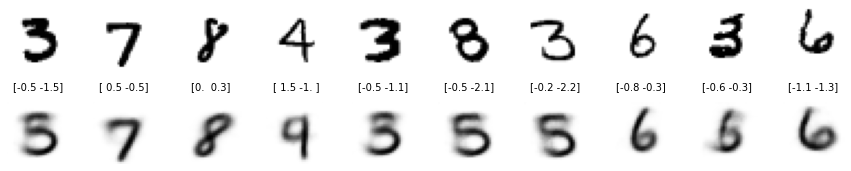

In [15]:
#reconstructing original paintings

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

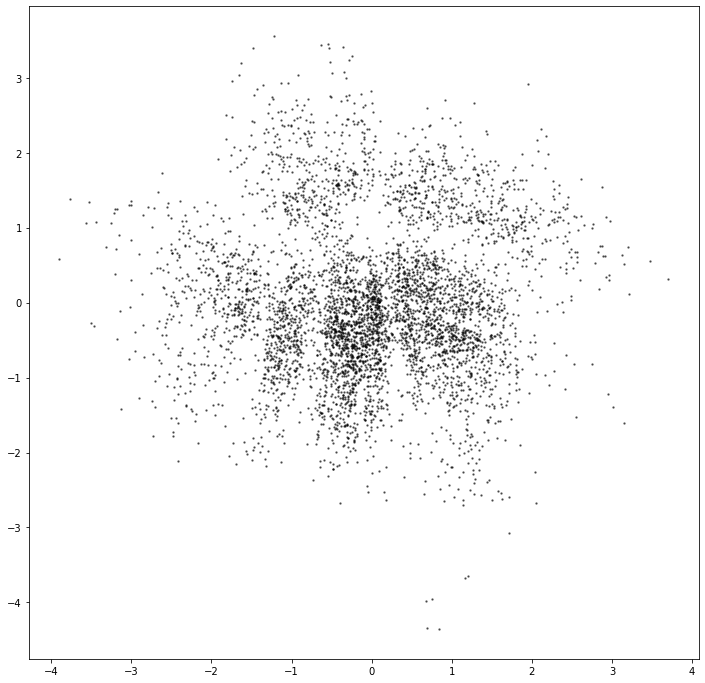

In [16]:
#Encoders space
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

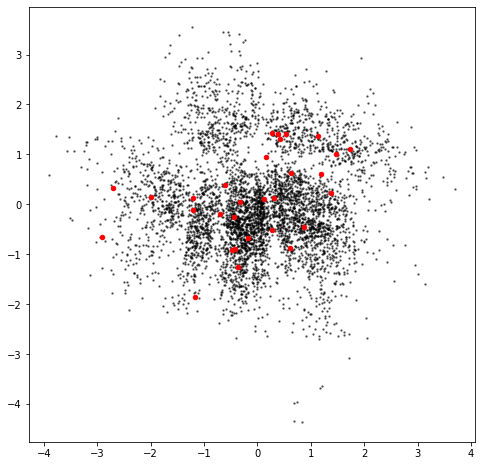

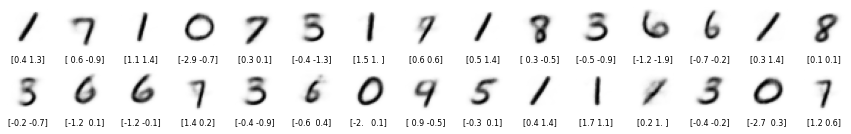

In [17]:
#Newly generated digits
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

In [ ]:
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')